In [1]:
import numpy as np
import os, sys
from constants import *
import argparse, time
from utils.net_utils import adjust_learning_rate
import torch
from torch.autograd import Variable
# from dataset.kitti_dataset import KittiDataset
from torchvision.transforms import RandomHorizontalFlip
from dataset.dataloader import *
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
# from path import Path
from torch.utils.data.sampler import Sampler
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid

from dataset.nyuv2_dataset import NYUv2Dataset
from model_fpn import I2D

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

class SLlog(nn.Module):
    def __init__(self):
        super(SLlog, self).__init__()
    
    def forward(self, fake, real):
        if not fake.shape == real.shape:
            _,_,H,W = real.shape
            fake = F.upsample(fake, size=(H,W), mode='bilinear')
            
        # filter out invalid pixels
        N = (real>0).float().sum()
        mask = (real==0)        
        fake[mask] = 1.
        real[mask] = 1.
        
        loss = 100.* torch.sum( torch.abs(torch.log(real)-torch.log(fake)) ) / N
        return loss

    
class RMSE_log(nn.Module):
    def __init__(self, use_cuda):
        super(RMSE_log, self).__init__()
        self.eps = 1e-8
        self.use_cuda = use_cuda
    
    def forward(self, fake, real):
        mask = real<1.
        n,_,h,w = real.size()
        fake = F.upsample(fake, size=(h,w), mode='bilinear')
        fake += self.eps

        N = len(real[mask])
        loss = torch.sqrt( torch.sum( torch.abs(torch.log(real[mask])-torch.log(fake[mask])) ** 2 ) / N )
        return loss

class iRMSE(nn.Module):
    def __init__(self):
        super(iRMSE, self).__init__()
        self.eps = 1e-8
    
    def forward(self, fake, real):
        n,_,h,w = real.size()
        fake = F.upsample(fake, size=(h,w), mode='bilinear')
        mask = real<1.
        n = len(real[mask])
        loss = torch.sqrt( torch.sum( torch.abs(1./real[mask] - 1./(fake[mask]+self.eps) ) ** 2 ) / n )
        return loss

def get_acc(output, target):
    # takes in two tensors to compute accuracy
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct_mask = pred.eq(target.data.view_as(pred))
    correct = correct_mask.cpu().sum()
    print("Target: ", Counter(target.data.cpu().numpy()))
    print("Pred: ", Counter(pred.cpu().numpy().flatten().tolist()))
    return float(correct)*100 / target.size(0) 
    

In [2]:
# network initialization
print('Initializing model...')
i2d = I2D(fixed_feature_weights=False)
i2d = i2d.cuda()

print('Done!')

reg_criterion = RMSE_log(use_cuda=True)
eval_metric = iRMSE()

# resume

load_name = '/disk2/i2d/saved_models_kitti/i2d_1_18.pth'
# print("loading checkpoint %s" % (load_name))
state = i2d.state_dict()
checkpoint = torch.load(load_name)
state.update(checkpoint['model'])
i2d.load_state_dict(state)

del checkpoint
torch.cuda.empty_cache()

# setting to train mode
i2d.eval()



Initializing model...
Done!


I2D(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): Batc

In [3]:
# img = Variable(torch.FloatTensor(1), volatile=True).cuda()
# z = Variable(torch.FloatTensor(1), volatile=True).cuda()

# test_loss = 0.
# for idx, (image, gt) in enumerate(train_dataloader):
#     img.data.resize_(image.size()).copy_(image)
#     z.data.resize_(gt.size()).copy_(gt)

#     d1,d2,d3,d4,d5 = i2d(img, None)
#     loss = reg_criterion(d1, z)
#     test_loss += loss.data[0]
#     print("Iter: %d/%d logRMSE: %.4f" \
#                     % (idx*bs, len(train_dataloader.dataset), loss))
    
# test_loss = test_loss * bs / len(train_dataloader.dataset)
# print('\nTest set: Average loss: {:.14f}'.format(test_loss))

vis_dataset = KittiDataset(train=False)
train_size = len(vis_dataset)

bs = 10
vis_dataloader = torch.utils.data.DataLoader(vis_dataset, batch_size=bs, shuffle=True)

(10, 1, 32, 160)
Variable containing:
 8.8532
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
1.00000e-02 *
  5.8663
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
1.00000e-02 *
  5.9994
[torch.cuda.FloatTensor of size 1 (GPU 0)]



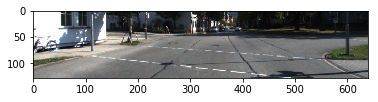

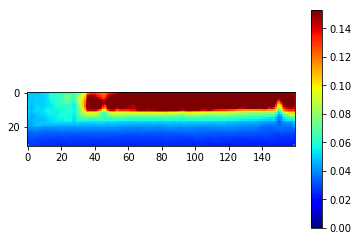

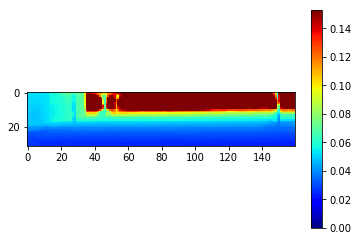

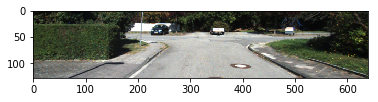

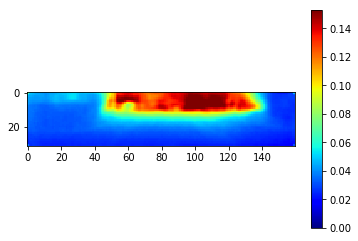

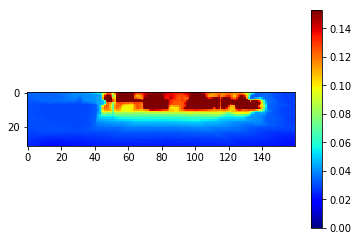

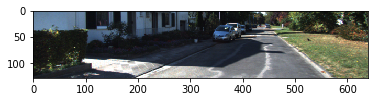

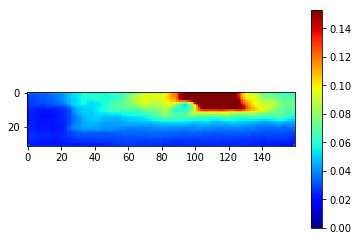

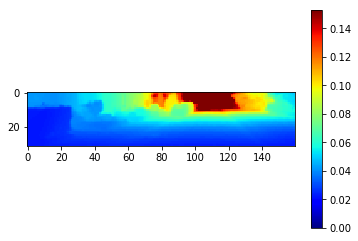

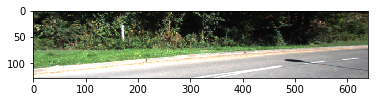

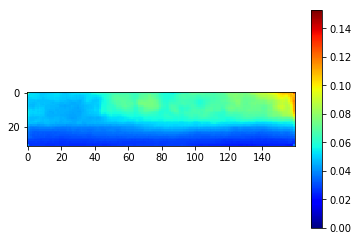

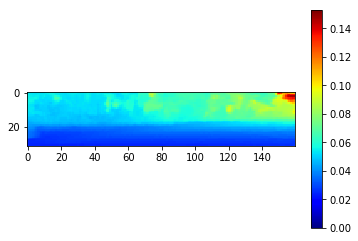

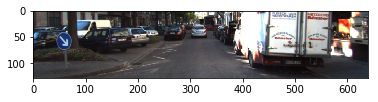

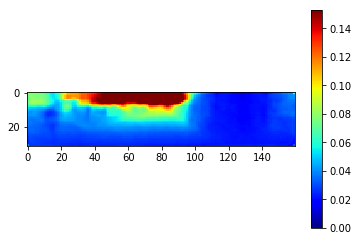

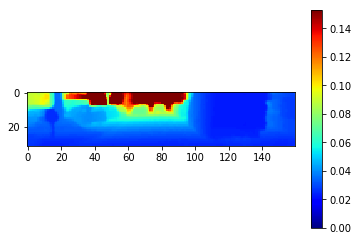

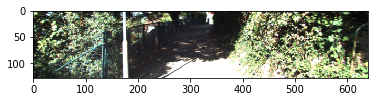

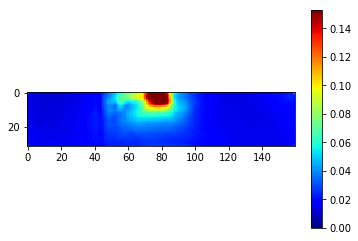

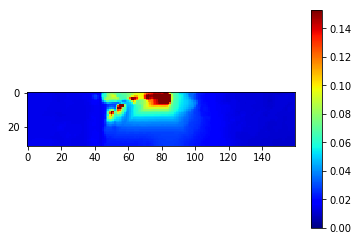

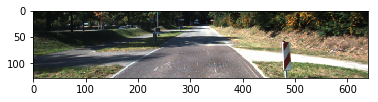

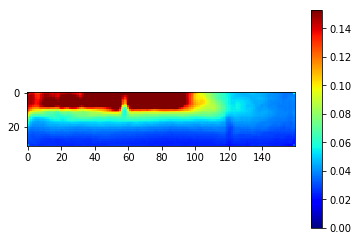

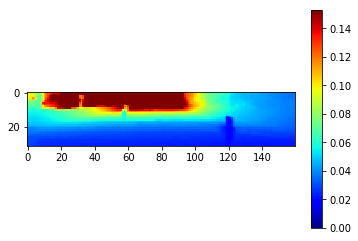

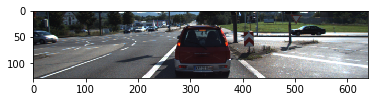

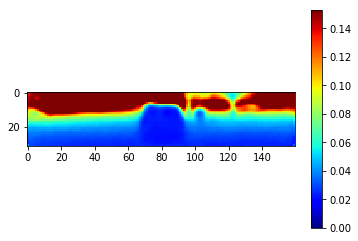

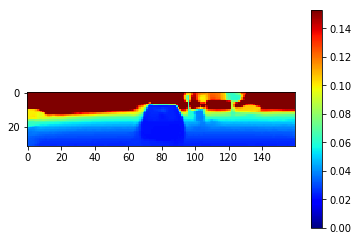

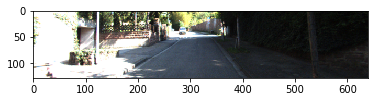

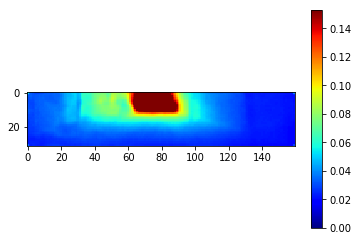

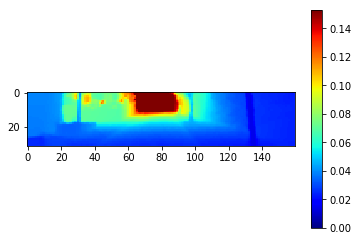

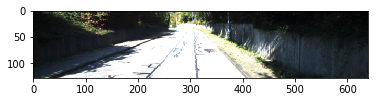

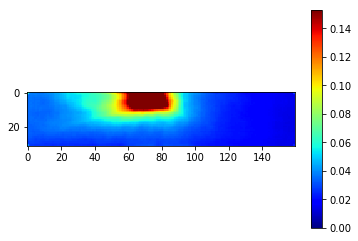

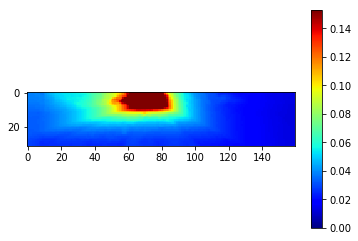

In [4]:
img = Variable(torch.FloatTensor(1), volatile=True).cuda()
z = Variable(torch.FloatTensor(1), volatile=True).cuda()

vis_data_iter = iter(vis_dataloader)

data = vis_data_iter.next()

img.data.resize_(data[0].size()).copy_(data[0])
z.data.resize_(data[1].size()).copy_(data[1])

z_fake = i2d(img)
# loss3 = reg_criterion(d1, z)
# loss = loss3

# metric = eval_metric(d1, z)

# print(d1.size())

# print("logRMSE: %.4f iRMSE: %.4f" \
#                 % (loss, metric))

imgs = img.data.cpu().numpy()
depth = z_fake.data.cpu().numpy()
gt = z.data.cpu().numpy()
print(gt.shape)

plt.set_cmap('jet')

sl_log = SLlog()
print(sl_log(z_fake, z), z_fake.mean(), z.mean())
for i in range(imgs.shape[0]):
    plt.imshow(np.transpose(imgs[i], (1, 2, 0)))
    plt.show()
    
    vmin, vmax = 0,10000/65536.
    plt.imshow(depth[i][0], vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()
    
    plt.imshow(gt[i][0], vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

In [5]:
# print(test_loss)
# print(len(train_dataloader.dataset))